2025-04-13 12:52:16,238 - INFO - Bắt đầu giải DDE thích nghi...
2025-04-13 12:52:16,240 - DEBUG - Adaptive step: thử với s=2, h=0.05
2025-04-13 12:52:16,241 - DEBUG - Gauss nodes (s=2): [0.21132487 0.78867513]
2025-04-13 12:52:16,242 - DEBUG - Lagrange basis L_0(s):  
-1.732 x + 1.366
2025-04-13 12:52:16,243 - DEBUG - Lagrange basis L_1(s):  
1.732 x - 0.366
2025-04-13 12:52:16,243 - DEBUG - Butcher tableau A:
[[ 0.25       -0.03867513]
 [ 0.53867513  0.25      ]]
, b: [0.5 0.5]
2025-04-13 12:52:16,243 - INFO - Initialized CollocationMethod: gauss with s=2
2025-04-13 12:52:16,244 - DEBUG - Bắt đầu giải hệ nonlinear với h=0.05 tại t=0.0.
2025-04-13 12:52:16,245 - DEBUG - Bước collocation hoàn thành: y(t+h) = [1.00711667]
2025-04-13 12:52:16,245 - DEBUG - Gauss nodes (s=1): [0.5]
2025-04-13 12:52:16,246 - DEBUG - Lagrange basis L_0(s):  
1
2025-04-13 12:52:16,247 - DEBUG - Butcher tableau A:
[[0.5]]
, b: [1.]
2025-04-13 12:52:16,247 - INFO - Initialized CollocationMethod: gauss with s=1


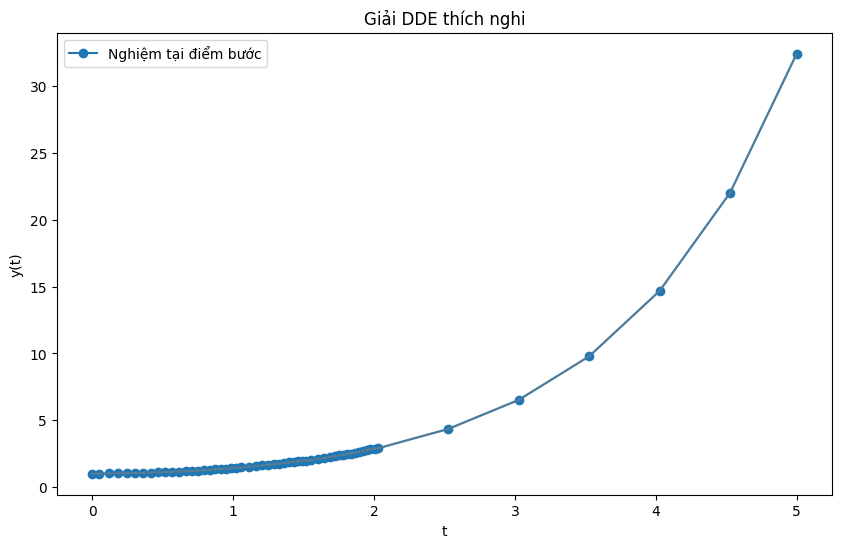

In [1]:
import numpy as np
import logging
from numpy.polynomial import Polynomial
from scipy.optimize import fsolve
from typing import Optional, List, Dict, Any, Callable, Tuple

# Cấu hình logging để dễ theo dõi quá trình tính toán
logger = logging.getLogger("CollocationSolver")
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)


# =============================================================================
# 1. Các hàm tính nút nội suy theo các phương pháp: Gauss, Radau, Lobatto, Chebyshev, Hermite
# =============================================================================

def get_gauss_nodes(s: int) -> np.ndarray:
    """
    Tính các nút Gauss-Legendre trên [0, 1].
    Sử dụng np.polynomial.legendre.leggauss trên [-1, 1] rồi chuyển đổi.
    """
    nodes, _ = np.polynomial.legendre.leggauss(s)
    c = 0.5 * (nodes + 1)
    logger.debug(f"Gauss nodes (s={s}): {c}")
    return c

def get_radau_nodes(s: int) -> np.ndarray:
    """
    Tính các nút Radau trên [0, 1] với nút cuối bằng 1.
    Trong phiên bản nâng cao, ta dùng phương pháp nội suy qua linspace với một chút điều chỉnh.
    """
    if s == 1:
        return np.array([1.0])
    else:
        # Sử dụng linspace rồi điều chỉnh nút đầu không bằng 0 (Radau không có 0)
        c = np.linspace(0, 1, s)
        c[0] = 0.1  # Điều chỉnh nhỏ, có thể thay đổi theo yêu cầu
        c[-1] = 1.0
        logger.debug(f"Radau nodes (s={s}): {c}")
        return c

def get_lobatto_nodes(s: int) -> np.ndarray:
    """
    Tính các nút Lobatto trên [0, 1] với đầu mút 0 và 1.
    Sử dụng công thức Chebyshev-Gauss-Lobatto.
    """
    if s < 2:
        raise ValueError("Phương pháp Lobatto yêu cầu ít nhất 2 nút.")
    i = np.arange(s)
    c = 0.5 * (1 - np.cos(np.pi * i / (s - 1)))
    logger.debug(f"Lobatto nodes (s={s}): {c}")
    return c

def get_chebyshev_nodes(s: int) -> np.ndarray:
    """
    Tính các nút Chebyshev trên [0, 1].
    Công thức: c_i = 0.5 * (1 - cos((2i-1)*pi/(2s))) với i=1,...,s.
    """
    i = np.arange(1, s + 1)
    c = 0.5 * (1 - np.cos((2 * i - 1) * np.pi / (2 * s)))
    logger.debug(f"Chebyshev nodes (s={s}): {c}")
    return c

def get_hermite_nodes(s: int) -> np.ndarray:
    """
    Đối với Hermite, trong ví dụ này ta sử dụng các nút Gauss làm cơ sở.
    Trong ứng dụng thực, Hermite collocation yêu cầu khớp thêm đạo hàm.
    """
    c = get_gauss_nodes(s)
    logger.debug(f"Hermite nodes (s={s}): {c}")
    return c


# =============================================================================
# 2. Xây dựng đa thức Lagrange và bảng Butcher (A, b)
# =============================================================================

def compute_lagrange_basis(c: np.ndarray, j: int) -> np.poly1d:
    """
    Tính đa thức Lagrange cơ sở L_j(s) dựa trên danh sách nút c.
    L_j(s) = ∏_{i ≠ j} (s - c[i])/(c[j] - c[i])
    """
    n = len(c)
    poly = np.poly1d([1.0])
    for i in range(n):
        if i != j:
            poly = np.polymul(poly, np.poly1d([1.0, -c[i]])) / (c[j] - c[i])
    logger.debug(f"Lagrange basis L_{j}(s): {poly}")
    return poly

def compute_butcher_tableau(c: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Tính bảng Butcher cho collocation method:
      a_{ij} = ∫_0^(c_i) L_j(s) ds,   b_j = ∫_0^1 L_j(s) ds.
    Sử dụng np.polyint để tính tích phân của đa thức.
    """
    s = len(c)
    A = np.zeros((s, s))
    b = np.zeros(s)
    for j in range(s):
        Lj = compute_lagrange_basis(c, j)
        Lj_int = np.poly1d(np.polyint(Lj.coeffs))
        b[j] = Lj_int(1) - Lj_int(0)
        for i in range(s):
            A[i, j] = Lj_int(c[i]) - Lj_int(0)
    logger.debug(f"Butcher tableau A:\n{A}\n, b: {b}")
    return A, b


# =============================================================================
# 3. Lớp đại diện cho phương pháp collocation với tùy chọn custom nodes và tính toán bảng Butcher
# =============================================================================

class CollocationMethod:
    """
    Lớp đại diện cho phương pháp collocation.
    Người dùng có thể chọn tên phương pháp (gauss, radau, lobatto, chebyshev, hermite)
    hoặc truyền vào các custom_nodes tùy chỉnh.
    
    Attributes:
      method_name: tên phương pháp dưới dạng chuỗi.
      s: số stage (số nút nội suy).
      c: mảng các nút nội suy.
      A: ma trận Butcher (hệ số nội suy cho các stage).
      b: vector Butcher (trọng số của các stage).
    """
    def __init__(self, method_name: str, s: int, custom_nodes: Optional[List[float]] = None):
        self.method_name = method_name.lower()
        self.s = s
        if custom_nodes is not None:
            self.c = np.array(custom_nodes, dtype=float)
            if len(self.c) != s:
                raise ValueError("Số điểm nội suy (custom_nodes) phải bằng s")
        else:
            if self.method_name == 'gauss':
                self.c = get_gauss_nodes(s)
            elif self.method_name == 'radau':
                self.c = get_radau_nodes(s)
            elif self.method_name == 'lobatto':
                self.c = get_lobatto_nodes(s)
            elif self.method_name == 'chebyshev':
                self.c = get_chebyshev_nodes(s)
            elif self.method_name == 'hermite':
                self.c = get_hermite_nodes(s)
            else:
                raise ValueError("Phương pháp chưa được hỗ trợ: " + method_name)
        self.A, self.b = compute_butcher_tableau(self.c)
        logger.info(f"Initialized CollocationMethod: {self.method_name} with s={self.s}")

    def continuous_extension(self, theta: float) -> np.ndarray:
        """
        Tính các hệ số mở rộng liên tục: b_i(theta) = ∫₀^θ L_i(s) ds.
        
        Args:
          theta: tham số nội suy trong [0, 1].
        
        Returns:
          mảng b_theta với kích thước (s,).
        """
        b_theta = np.zeros(self.s)
        for j in range(self.s):
            Lj = compute_lagrange_basis(self.c, j)
            Lj_int = np.poly1d(np.polyint(Lj.coeffs))
            b_theta[j] = Lj_int(theta) - Lj_int(0)
        logger.debug(f"Continuous extension at theta={theta}: {b_theta}")
        return b_theta


# =============================================================================
# 4. Hàm ước lượng thứ tự (order) của phương pháp collocation dựa trên method_name và s
# =============================================================================

def collocation_order(method_name: str, s: int) -> int:
    """
    Trả về thứ tự (order) discrete của phương pháp collocation dựa trên số stage s.
    Ví dụ:
      - Gauss: order = 2*s
      - Radau: order = 2*s - 1
      - Lobatto: order = 2*s - 2
      - Các phương pháp khác: mặc định order = s (có thể tùy chỉnh thêm)
    """
    m = method_name.lower()
    if m == 'gauss':
        order_val = 2 * s
    elif m == 'radau':
        order_val = 2 * s - 1
    elif m == 'lobatto':
        order_val = 2 * s - 2
    else:
        order_val = s
    logger.debug(f"Collocation order for {method_name} with s={s}: {order_val}")
    return order_val

def get_embedded_collocation(method_name: str, s: int, custom_nodes: Optional[List[float]] = None) -> Optional[CollocationMethod]:
    """
    Trả về một đối tượng CollocationMethod với số stage embedded = s - 1, dùng để ước lượng sai số.
    Nếu s <= 1, không tồn tại embedded pair.
    """
    if s <= 1:
        logger.warning("Embedded pair không khả dụng với s <= 1.")
        return None
    return CollocationMethod(method_name, s - 1, custom_nodes=custom_nodes)


# =============================================================================
# 5. Lịch sử giải (History) và hàm nội suy cho DDE
# =============================================================================

def get_history_value(t: float,
                      history_segments: List[Dict[str, Any]],
                      phi: Callable[[float], np.ndarray],
                      t0: float) -> np.ndarray:
    """
    Trả về giá trị y(t) dựa trên lịch sử giải:
      - Nếu t <= t0: trả về giá trị từ hàm lịch sử phi(t).
      - Nếu t nằm trong một đoạn giải, sử dụng continuous extension của bước đó.
      - Nếu t > thời gian đã giải, trả về giá trị cuối cùng.
    
    Args:
      t: thời điểm cần nội suy.
      history_segments: danh sách các đoạn đã giải, mỗi đoạn là dict chứa
                        't_start', 't_end', 'h', 'y_start', 'collocation', 'K'.
      phi: hàm lịch sử ban đầu cho t <= t0.
      t0: thời điểm bắt đầu giải.
    
    Returns:
      y_value: giá trị nội suy của y tại thời điểm t.
    """
    if t <= t0 or not history_segments:
        return phi(t)
    for seg in history_segments:
        if seg['t_start'] <= t <= seg['t_end']:
            theta = (t - seg['t_start']) / seg['h']
            b_theta = seg['collocation'].continuous_extension(theta)
            y_value = seg['y_start'] + seg['h'] * np.dot(b_theta, seg['K'])
            logger.debug(f"History value at t={t} found in segment [{seg['t_start']}, {seg['t_end']}].")
            return y_value
    # Nếu không nằm trong bất kỳ segment nào, trả về giá trị cuối cùng
    seg = history_segments[-1]
    y_value = seg['y_start'] + seg['h'] * np.dot(seg['collocation'].b, seg['K'])
    logger.debug(f"History value at t={t} using final segment.")
    return y_value


# =============================================================================
# 6. Bước collocation cho DDE (phiên bản nâng cao)
# =============================================================================

def collocation_step_dde(f: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                         tau: Callable[[float, np.ndarray], float],
                         get_history_value_func: Callable[..., np.ndarray],
                         phi: Callable[[float], np.ndarray],
                         t: float, y: np.ndarray, h: float,
                         collocation: CollocationMethod,
                         t0: float,
                         history_segments: List[Dict[str, Any]]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Giải một bước của DDE trên [t, t+h] theo phương pháp collocation:
      Tìm các stage K_i từ hệ phương trình:
         K_i = f(t_i, y_i, y(t_i - τ(t_i, y_i))),
      với:
         t_i = t + c_i * h,
         y_i = y + h * Σ_j A[i, j] * K_j.
    
    Args:
      f: hàm định nghĩa y'(t) = f(t, y(t), y(t-τ)).
      tau: hàm định nghĩa độ trễ τ(t, y).
      get_history_value_func: hàm nội suy lịch sử.
      phi: hàm lịch sử ban đầu.
      t: thời điểm bắt đầu bước.
      y: giá trị y(t) hiện tại.
      h: bước số.
      collocation: đối tượng CollocationMethod hiện hành.
      t0: thời điểm khởi đầu (cho lịch sử).
      history_segments: danh sách các đoạn giải (dùng cho nội suy giá trị trễ).
    
    Returns:
      y_next: giá trị y tại t+h.
      K: mảng các stage K (kích thước (s, dim(y))).
    """
    s = collocation.s
    c = collocation.c
    A = collocation.A

    def F(K_flat: np.ndarray) -> np.ndarray:
        K = K_flat.reshape((s,) + y.shape)
        F_val = np.zeros_like(K)
        for i in range(s):
            t_i = t + c[i] * h
            y_i = y.copy()
            for j in range(s):
                y_i += h * A[i, j] * K[j]
            # Xác định thời gian trễ: t_delay = t_i - τ(t_i, y_i)
            t_delay = t_i - tau(t_i, y_i)
            y_delay = get_history_value_func(t_delay, history_segments, phi, t0)
            F_val[i] = K[i] - f(t_i, y_i, y_delay)
        return F_val.flatten()

    # Đoán ban đầu cho K
    K0 = np.zeros((s,) + y.shape)
    logger.debug(f"Bắt đầu giải hệ nonlinear với h={h} tại t={t}.")
    K_flat = fsolve(F, K0.flatten())
    K = K_flat.reshape((s,) + y.shape)
    y_next = y.copy()
    for j in range(s):
        y_next += h * collocation.b[j] * K[j]
    logger.debug(f"Bước collocation hoàn thành: y(t+h) = {y_next}")
    return y_next, K


# =============================================================================
# 7. Adaptive bước số với embedded pair và điều chỉnh số stage
# =============================================================================

def adaptive_collocation_step_dde(f: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                  tau: Callable[[float, np.ndarray], float],
                                  get_history_value_func: Callable[..., np.ndarray],
                                  phi: Callable[[float], np.ndarray],
                                  t: float, y: np.ndarray, h: float,
                                  method_name: str, s: int, t0: float,
                                  history_segments: List[Dict[str, Any]],
                                  custom_nodes: Optional[List[float]] = None,
                                  tol: float = 1e-5,
                                  safety: float = 0.9,
                                  h_min: float = 1e-6,
                                  h_max: float = 1.0,
                                  max_reject: int = 10) -> Tuple[np.ndarray, np.ndarray, float, int, bool]:
    """
    Thực hiện một bước thích nghi cho DDE với collocation.
    
    Các bước:
      - Tính nghiệm đầy đủ y_full với s stage.
      - Tính nghiệm embedded y_emb với s_emb = s - 1 (nếu có).
      - Ước lượng sai số e = ||y_full - y_emb|| (dùng norm Euclid).
      - Nếu e <= tol: chấp nhận bước và ước lượng bước mới.
      - Nếu e > tol: giảm bước h theo công thức và thử lại.
      - Nếu liên tục từ chối quá nhiều lần, tăng số stage (s_current).
    
    Returns:
      y_full: nghiệm đầy đủ tại t+h.
      K_full: các stage tương ứng.
      h_new: bước số mới được đề xuất.
      s_new: số stage hiện hành (có thể tăng lên).
      accepted: True nếu bước được chấp nhận.
    """
    reject_count = 0
    s_current = s
    while True:
        logger.debug(f"Adaptive step: thử với s={s_current}, h={h}")
        colloc_full = CollocationMethod(method_name, s_current, custom_nodes=custom_nodes)
        y_full, K_full = collocation_step_dde(f, tau, get_history_value_func, phi, t, y, h, colloc_full, t0, history_segments)
        
        embedded = get_embedded_collocation(method_name, s_current, custom_nodes=custom_nodes)
        if embedded is None:
            # Sử dụng phương pháp hai bước (step-doubling) khi không có embedded pair
            y_mid, _ = collocation_step_dde(f, tau, get_history_value_func, phi, t, y, h / 2, colloc_full, t0, history_segments)
            y_two, _ = collocation_step_dde(f, tau, get_history_value_func, phi, t + h / 2, y_mid, h / 2, colloc_full, t0, history_segments)
            y_emb = y_two
            order_emb = 1  # ước lượng đơn giản
        else:
            y_emb, _ = collocation_step_dde(f, tau, get_history_value_func, phi, t, y, h, embedded, t0, history_segments)
            order_emb = collocation_order(method_name, s_current - 1)
        
        err = np.linalg.norm(y_full - y_emb)
        p_emb = order_emb
        logger.debug(f"Ước lượng sai số: {err} (tol={tol}) với p_emb={p_emb}")
        if err <= tol:
            # Chấp nhận bước, tính bước mới theo công thức điều chỉnh
            h_new = h * safety * (tol / (err + 1e-16)) ** (1 / (p_emb + 1))
            h_new = np.clip(h_new, h_min, h_max)
            logger.info(f"Bước chấp nhận với h_new = {h_new}")
            return y_full, K_full, h_new, s_current, True
        else:
            # Từ chối bước, giảm bước h và tăng reject_count
            h = h * safety * (tol / (err + 1e-16)) ** (1 / (p_emb + 1))
            h = max(h, h_min)
            reject_count += 1
            logger.warning(f"Bước từ chối (err={err}). Thử lại với h={h}")
            if reject_count >= max_reject:
                s_current += 1
                logger.warning(f"Tăng số stage lên {s_current} do từ chối quá nhiều lần.")
                reject_count = 0
            if h < h_min:
                raise RuntimeError("Bước số giảm dưới mức cho phép, không hội tụ được.")


# =============================================================================
# 8. Adaptive solver cho DDE với method of steps
# =============================================================================

def solve_dde_collocation_adaptive(f: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                   tau: Callable[[float, np.ndarray], float],
                                   phi: Callable[[float], np.ndarray],
                                   t0: float, t_end: float, h0: float,
                                   method_name: str = 'gauss', s0: int = 2,
                                   custom_nodes: Optional[List[float]] = None,
                                   tol: float = 1e-5,
                                   safety: float = 0.9,
                                   h_min: float = 1e-6,
                                   h_max: float = 1.0,
                                   max_reject: int = 10) -> Tuple[np.ndarray, np.ndarray, List[Dict[str, Any]]]:
    """
    Giải DDE:
         y'(t) = f(t, y(t), y(t - τ(t, y(t)))),
         y(t) = φ(t) cho t <= t0,
    trên khoảng [t0, t_end] với bước số thích nghi bằng phương pháp method of steps.
    
    Args:
      f: hàm định nghĩa hệ DDE.
      tau: hàm định nghĩa độ trễ τ(t, y).
      phi: hàm lịch sử cho t <= t0.
      t0: thời điểm bắt đầu giải.
      t_end: thời điểm kết thúc giải.
      h0: bước số ban đầu.
      method_name: tên phương pháp collocation (gauss, radau, lobatto, chebyshev, hermite, ...).
      s0: số stage ban đầu.
      custom_nodes: nếu cung cấp, dùng để định nghĩa các điểm nội suy tùy chỉnh.
      tol: sai số cho bước thích nghi.
      safety, h_min, h_max, max_reject: các tham số điều khiển bước thích nghi.
    
    Returns:
      ts: mảng thời gian các điểm bước.
      ys: mảng nghiệm tại các điểm bước.
      history_segments: danh sách các đoạn giải (dùng cho nội suy các giá trị trễ).
    """
    t = t0
    y = phi(t0)
    ts = [t0]
    ys = [y.copy()]
    history_segments: List[Dict[str, Any]] = []
    h = h0
    s_current = s0
    
    logger.info("Bắt đầu giải DDE thích nghi...")
    while t < t_end:
        if t + h > t_end:
            h = t_end - t
        try:
            y_next, K, h_new, s_current, accepted = adaptive_collocation_step_dde(
                f, tau, get_history_value, phi, t, y, h,
                method_name, s_current, t0, history_segments,
                custom_nodes=custom_nodes, tol=tol, safety=safety,
                h_min=h_min, h_max=h_max, max_reject=max_reject
            )
        except RuntimeError as e:
            logger.error(f"Lỗi khi giải tại t={t}: {e}")
            break

        if accepted:
            colloc = CollocationMethod(method_name, s_current, custom_nodes=custom_nodes)
            segment = {
                't_start': t,
                't_end': t + h,
                'y_start': y.copy(),
                'h': h,
                'collocation': colloc,
                'K': K
            }
            history_segments.append(segment)
            t += h
            y = y_next.copy()
            ts.append(t)
            ys.append(y.copy())
            h = h_new
            logger.info(f"Bước thành công: t = {t}, h = {h}")
        else:
            h = h_new
    return np.array(ts), np.array(ys), history_segments


# =============================================================================
# Ví dụ minh họa (sử dụng các hàm/lớp trên)
# =============================================================================

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Định nghĩa hàm f: f(t, u, v) = -u + v
    def f(t: float, y: np.ndarray, y_delay: np.ndarray) -> np.ndarray:
        return y_delay


    # Hàm τ: độ trễ hằng số 1
    def tau(t: float, y: np.ndarray) -> float:
        return 2-t

    # Hàm lịch sử: φ(t) = 1 cho mọi t <= t0
    def phi(t: float) -> np.ndarray:
        return np.array([np.exp(t)])

    t0 = 0.0
    t_end = 5.0
    h0 = 0.05  # bước số ban đầu
    # Các ước lượng Lipschitz có thể được tích hợp vào hệ thống điều khiển bước số nếu cần
    ts, ys, history_segments = solve_dde_collocation_adaptive(
        f, tau, phi, t0, t_end, h0,
        method_name='gauss', s0=2, custom_nodes=None,
        tol=1e-5, safety=0.9, h_min=1e-6, h_max=0.5, max_reject=5
    )

    # Vẽ đồ thị nghiệm tại các điểm bước và nội suy trên mỗi đoạn
    plt.figure(figsize=(10, 6))
    plt.plot(ts, ys[:, 0], 'o-', label='Nghiệm tại điểm bước')
    for seg in history_segments:
        t_start, t_end_seg, h_seg = seg['t_start'], seg['t_end'], seg['h']
        coll = seg['collocation']
        t_vals = np.linspace(t_start, t_end_seg, 50)
        y_vals = []
        for t_val in t_vals:
            theta = (t_val - t_start) / h_seg
            b_theta = coll.continuous_extension(theta)
            y_val = seg['y_start'] + h_seg * np.dot(b_theta, seg['K'])
            y_vals.append(y_val[0])
        plt.plot(t_vals, y_vals, '-', color='gray', alpha=0.5)
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title("Giải DDE thích nghi")
    plt.legend()
    plt.show()

# if __name__ == "__main__":
#     def f(t, u, v):
#         return np.array([np.e**2 * v])

#     def tau(t, y):
#         return 2.0

#     def phi(t):
#         return np.array([np.exp(t)])
    
#     t0 = 0.0
#     t_end = 5.0
#     h0 = 0.05  # bước số ban đầu
#     # Các ước lượng Lipschitz (chỉ để nhắc đến; có thể dùng để điều khiển bước số nâng cao hơn)
#     L_f_u = 1.0
#     L_f_v = 1.0
#     L_tau_y = 0.0  # Với τ =1, không phụ thuộc vào y
    
#     # Chọn phương pháp collocation: ví dụ 'gauss'
#     ts, ys, history_segments = solve_dde_collocation_adaptive(
#         f, tau, phi, t0, t_end, h0, 
#         method_name='gauss', s0=2, custom_nodes=None, 
#         tol=1e-5, safety=0.9, h_min=1e-6, h_max=0.1, max_reject=5)
    
#     # Vẽ đồ thị nghiệm tại các điểm bước và nội suy trên mỗi bước
#     plt.figure(figsize=(10,6))
#     plt.plot(ts, ys[:,0], label='Nghiệm tại điểm bước')
    
#     # Vẽ nội suy cho mỗi đoạn
#     for seg in history_segments:
#         t_start, t_end_seg, h_seg = seg['t_start'], seg['t_end'], seg['h']
#         coll = seg['collocation']
#         t_vals = np.linspace(t_start, t_end_seg, 50)
#         y_vals = []
#         for t_val in t_vals:
#             theta = (t_val - t_start) / h_seg
#             b_theta = coll.continuous_extension(theta)
#             y_val = seg['y_start'] + h_seg * np.dot(b_theta, seg['K'])
#             y_vals.append(y_val[0])
#         plt.plot(t_vals, y_vals, '-', color='gray', alpha=0.5)
    
#     plt.xlabel('t')
#     plt.ylabel('y(t)')
#     plt.title("Giải DDE thích nghi")
#     plt.legend()
#     plt.show()


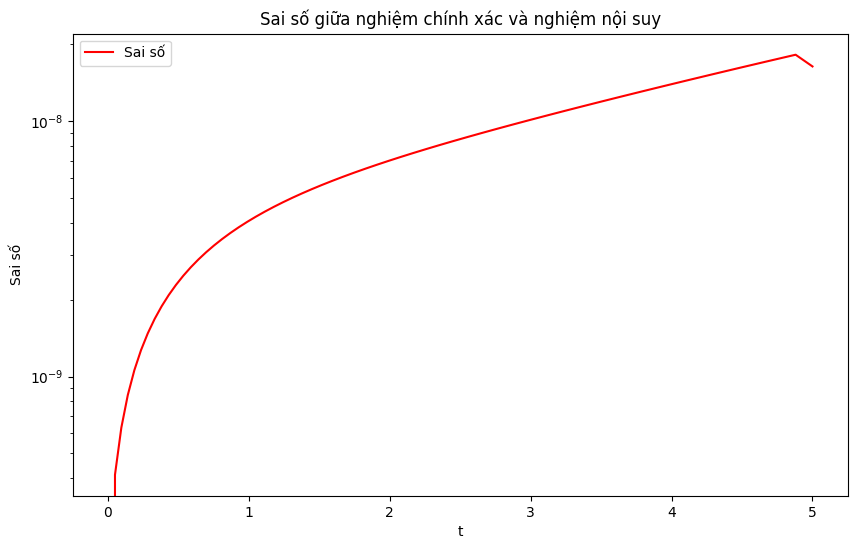

In [69]:
def y_exact(t):
    """Giá trị chính xác của nghiệm cho bài toán này."""
    return np.exp(-t)
#tính sai số
def compute_error(ts, ys):
    """Tính sai số giữa nghiệm chính xác và nghiệm nội suy."""
    errors = np.abs(ys[:,0] - y_exact(ts))
    return errors
#vẽ đồ thị sai số vừa tính
def plot_error(ts, errors):
    """Vẽ đồ thị sai số."""
    plt.figure(figsize=(10,6))
    plt.plot(ts, errors, 'r-', label='Sai số')
    plt.xlabel('t')
    plt.ylabel('Sai số')
    plt.yscale('log')
    plt.title("Sai số giữa nghiệm chính xác và nghiệm nội suy")
    plt.legend()
    plt.show()
plot_error(ts, compute_error(ts, ys))


In [38]:
len(ts)

226

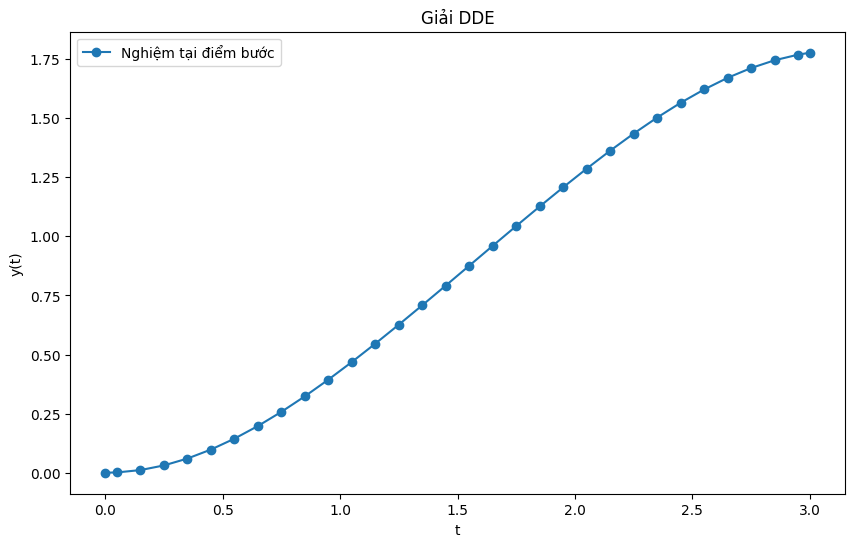

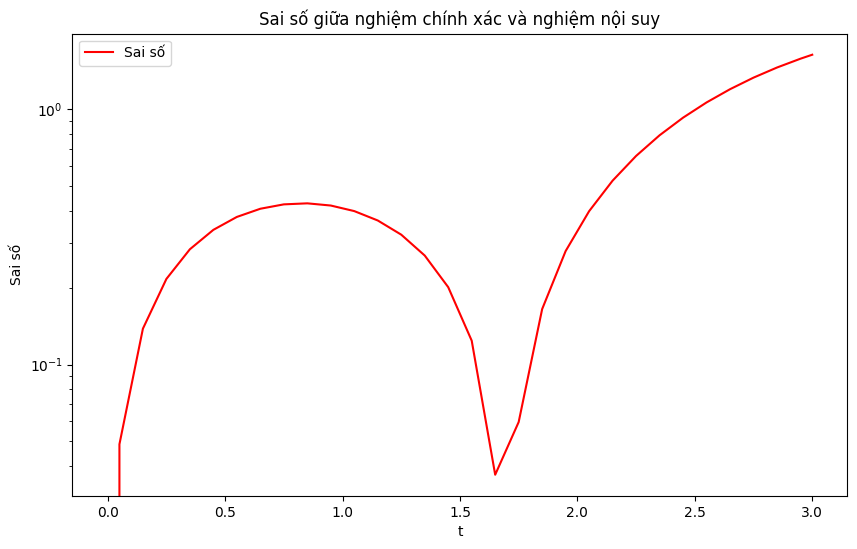

In [4]:
import numpy as np
from numpy.polynomial import Polynomial
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numdifftools as nd

# =====================================================
# 1. Các hàm tính nút nội suy cho các phương pháp collocation
# =====================================================

def get_gauss_nodes(s):
    """Tính các nút Gauss-Legendre trên [0,1]."""
    nodes, _ = np.polynomial.legendre.leggauss(s)
    c = 0.5 * (nodes + 1)
    return c

def get_radau_nodes(s):
    """Tính xấp xỉ các nút Radau trên [0,1] với c_s = 1.
       (Cách xấp xỉ đơn giản, thay đổi tùy nhu cầu)"""
    if s == 1:
        return np.array([1.0])
    else:
        c = np.linspace(0, 1, s)
        c[0] = 0.1  # tránh lấy 0, vì Radau thường không lấy 0
        c[-1] = 1.0
        return c

def get_lobatto_nodes(s):
    """Tính các nút Lobatto trên [0,1] với đầu mút 0 và 1."""
    if s == 2:
        return np.array([0.0, 1.0])
    else:
        i = np.arange(0, s)
        c = 0.5 * (1 - np.cos(np.pi * i / (s - 1)))
        return c

def get_chebyshev_nodes(s):
    """Tính các nút Chebyshev trên [0,1]."""
    i = np.arange(1, s + 1)
    c = 0.5 * (1 - np.cos((2 * i - 1) * np.pi / (2 * s)))
    return c

def get_hermite_nodes(s):
    """Ở ví dụ này, ta dùng nút Gauss làm nút cơ bản cho Hermite."""
    return get_gauss_nodes(s)

# =====================================================
# 2. Xây dựng đa thức Lagrange và bảng Butcher
# =====================================================

def compute_lagrange_basis(c, j):
    """
    Tính đa thức cơ sở Lagrange L_j(s) với các nút c:
      L_j(s) = Π_{i ≠ j} (s - c_i)/(c_j - c_i)
    Trả về một đối tượng np.poly1d.
    """
    n = len(c)
    poly = np.poly1d([1.0])
    for i in range(n):
        if i != j:
            poly = np.polymul(poly, np.poly1d([1.0, -c[i]])) / (c[j] - c[i])
    return poly

def compute_butcher_tableau(c):
    """
    Tính bảng Butcher dựa trên các nút collocation:
      a_{ij} = ∫₀^(c_i) L_j(s) ds,   b_j = ∫₀^1 L_j(s) ds.
    """
    s = len(c)
    A = np.zeros((s, s))
    b = np.zeros(s)
    for j in range(s):
        Lj = compute_lagrange_basis(c, j)
        Lj_int = np.poly1d(np.polyint(Lj.coeffs))
        b[j] = Lj_int(1) - Lj_int(0)
        for i in range(s):
            A[i, j] = Lj_int(c[i]) - Lj_int(0)
    return A, b

class CollocationMethod:
    """
    Lớp đại diện cho phương pháp collocation.
    Các phương pháp được hỗ trợ: 'gauss', 'radau', 'lobatto', 'chebyshev', 'hermite'
    """
    def __init__(self, method_name, s):
        self.method_name = method_name.lower()
        self.s = s
        if self.method_name == 'gauss':
            self.c = get_gauss_nodes(s)
        elif self.method_name == 'radau':
            self.c = get_radau_nodes(s)
        elif self.method_name == 'lobatto':
            self.c = get_lobatto_nodes(s)
        elif self.method_name == 'chebyshev':
            self.c = get_chebyshev_nodes(s)
        elif self.method_name == 'hermite':
            self.c = get_hermite_nodes(s)
        else:
            raise ValueError("Phương pháp chưa được hỗ trợ: " + method_name)
        self.A, self.b = compute_butcher_tableau(self.c)
    
    def continuous_extension(self, theta):
        """
        Tính các hệ số mở rộng liên tục: 
          b_i(theta) = ∫₀^θ L_i(s) ds, với θ ∈ [0,1].
        """
        s = self.s
        b_theta = np.zeros(s)
        for j in range(s):
            Lj = compute_lagrange_basis(self.c, j)
            Lj_int = np.poly1d(np.polyint(Lj.coeffs))
            b_theta[j] = Lj_int(theta) - Lj_int(0)
        return b_theta

# =====================================================
# 3. Hàm lấy giá trị lịch sử (History) và nội suy
# =====================================================

def get_history_value(t, history_segments, phi, t0):
    """
    Trả về giá trị y(t) dựa trên lịch sử:
      - Nếu t <= t0, trả về hàm lịch sử φ(t).
      - Nếu t nằm trong một đoạn đã tính, sử dụng phần mở rộng liên tục.
    """
    if t <= t0:
        return phi(t)
    for seg in history_segments:
        if seg['t_start'] <= t <= seg['t_end']:
            theta = (t - seg['t_start']) / seg['h']
            b_theta = seg['collocation'].continuous_extension(theta)
            return seg['y_start'] + seg['h'] * np.dot(b_theta, seg['K'])
    seg = history_segments[-1]
    return seg['y_start'] + seg['h'] * np.dot(seg['collocation'].b, seg['K'])

# =====================================================
# 4. Hàm bước collocation cho DDE (một bước từ t đến t+h)
# =====================================================

def collocation_step_dde(f, tau, get_history_value_func, phi, t, y, h, collocation, t0, history_segments):
    """
    Giải một bước DDE trên [t, t+h]:
      Tìm K_i (i=1,...,s) sao cho:
         K_i = f( t + c_i*h,  y + h*Σ_j A[i,j]*K_j,  y( t+c_i*h - τ(t+c_i*h, y_i) ) )
      với y_i = y + h*Σ_j A[i,j]*K_j.
    Giải hệ phi tuyến này bằng fsolve.
    """
    s = collocation.s
    c = collocation.c
    A = collocation.A
    
    def F(K_flat):
        K = K_flat.reshape((s,) + y.shape)
        F_val = np.zeros_like(K)
        for i in range(s):
            t_i = t + c[i] * h
            # Ước lượng y tại t_i
            y_i = y.copy()
            for j in range(s):
                y_i += h * A[i, j] * K[j]
            # Tính thời gian trễ
            t_delay = t_i - tau(t_i, y_i)
            y_delay = get_history_value_func(t_delay, history_segments, phi, t0)
            F_val[i] = K[i] - f(t_i, y_i, y_delay)
        return F_val.flatten()
    
    K0 = np.zeros((s,) + y.shape)
    K_flat = fsolve(F, K0.flatten())
    K = K_flat.reshape((s,) + y.shape)
    
    y_next = y.copy()
    for j in range(s):
        y_next += h * collocation.b[j] * K[j]
    return y_next, K

# =====================================================
# 5. Hàm lấy "order" của phương pháp (discrete order p)
# =====================================================

def get_method_order(method_name, s):
    """
    Ước lượng bậc của phương pháp collocation:
      - Gauss: p = 2*s,
      - Radau: p = 2*s - 1,
      - Lobatto: p = 2*s - 2,
      - Chebyshev: giả sử p = s,
      - Hermite: giả sử p = 2*s.
    """
    method = method_name.lower()
    if method == 'gauss':
        return 2 * s
    elif method == 'radau':
        return 2 * s - 1
    elif method == 'lobatto':
        return 2 * s - 2
    elif method == 'chebyshev':
        return s
    elif method == 'hermite':
        return 2 * s
    else:
        raise ValueError("Không xác định được bậc cho phương pháp: " + method_name)

# =====================================================
# 6. Thuật toán đa bước thích nghi (Adaptive step size) cho DDE
# =====================================================

def solve_dde_collocation_adaptive(f, tau, phi, t0, t_end, h0, method_name='gauss', s=2, tol=1e-4,
                                   L_f_u=None, L_f_v=None, L_tau_y=None, h_min=1e-6, h_max=1.0):
    """
    Giải DDE:
        y'(t)= f(t, y(t), y(t-τ(t,y(t)))),
        y(t)= φ(t) cho t<= t0,
    với thuật toán bước thích nghi sử dụng kỹ thuật step doubling.
    
    - h0: bước khởi đầu,
    - tol: sai số chấp nhận được (local error tolerance).
    
    Các ước lượng Lipschitz (L_f_u, L_f_v, L_tau_y) được truyền vào nhằm nhắc rằng cần đảm bảo
    tính đặt chỉnh của bài toán; trong ví dụ này chưa dùng trực tiếp để điều chỉnh bước.
    
    Trả về:
      ts: mảng thời gian của các bước,
      ys: nghiệm tại các điểm bước.
    """
    collocation = CollocationMethod(method_name, s)
    t = t0
    # Đảm bảo rằng giá trị ban đầu luôn là mảng có ít nhất một chiều
    y = np.atleast_1d(phi(t0))
    ts = [t0]
    ys = [y.copy()]
    history_segments = []  # lưu trữ các đoạn nghiệm đã tính
    
    h = h0
    p = get_method_order(method_name, s)
    
    SAFETY = 0.9  # hệ số an toàn khi điều chỉnh bước
    
    while t < t_end:
        if t + h > t_end:
            h = t_end - t
        
        # Lưu lại history_segments trước bước, nếu bước sau bị reject sẽ khôi phục
        history_backup = history_segments.copy()
        
        # Tính nghiệm một bước với bước h (solution full)
        y_full, K_full = collocation_step_dde(f, tau, get_history_value, phi, t, y, h, collocation, t0, history_segments)
        
        # Tính nghiệm qua hai bước với bước h/2 (step doubling)
        # Bước 1: từ t đến t+h/2
        y_mid, K_mid = collocation_step_dde(f, tau, get_history_value, phi, t, y, h/2, collocation, t0, history_segments)
        seg_mid = {
            't_start': t,
            't_end': t + h/2,
            'y_start': y.copy(),
            'h': h/2,
            'collocation': collocation,
            'K': K_mid
        }
        history_half = history_segments.copy()
        history_half.append(seg_mid)
        # Bước 2: từ t+h/2 đến t+h, dùng y_mid làm giá trị khởi đầu
        y_half, K_half = collocation_step_dde(f, tau, get_history_value, phi, t + h/2, y_mid, h/2, collocation, t0, history_half)
        
        # Ước tính sai số theo kỹ thuật step doubling:
        # sai số ~ ||y_half - y_full|| / (2^p - 1)
        error_est = np.linalg.norm(y_half - y_full) / (2**p - 1)
        
        if error_est < tol:
            # Bước được chấp nhận: cập nhật t, y và lưu history
            t += h
            y = y_half.copy()
            ts.append(t)
            ys.append(y.copy())
            seg = {
                't_start': ts[-2],
                't_end': t,
                'y_start': ys[-2].copy(),
                'h': h,
                'collocation': collocation,
                'K': K_full  # lưu lại hệ số K từ bước full
            }
            history_segments.append(seg)
            # Điều chỉnh bước mới (có thể tăng nếu sai số nhỏ)
            factor = SAFETY * (tol / error_est)**(1/(p+1))
            h = min(h * min(2.0, max(0.1, factor)), h_max)
        else:
            # Bước không chấp nhận, giảm bước và thử lại
            factor = SAFETY * (tol / error_est)**(1/(p+1))
            h = max(h * max(0.1, factor), h_min)
            history_segments = history_backup  # khôi phục lại history
            print(f"Step rejected at t={t:.4f}, error={error_est:.2e}, new h={h:.2e}")
    
    return np.array(ts), np.array(ys)

# =====================================================
# Chạy ví dụ chính
# =====================================================

if __name__ == "__main__":
    # Định nghĩa hàm F và dẫn hàm dF (sử dụng numdifftools)
    def F(t):
        return np.log(1 + t**2) + np.sqrt(1 + t**4)
    
    def dF(t):
        df = nd.Derivative(F)
        return df(t)
    
    # Định nghĩa hàm tau, phi và f, đảm bảo đầu ra luôn là mảng với ít nhất 1 chiều
    def tau(t, y):
        return np.pi
    
    def phi(t):
        return np.atleast_1d(np.sin(t))
    
    def f(t, y, y_delay):
        y = np.atleast_1d(y)
        y_delay = np.atleast_1d(y_delay)
        return -np.sin(y_delay)
    
    # Các thiết lập thời gian và bước ban đầu
    t0 = 0
    t_end = 3
    h0 = 0.05
    tol = 1e-6
    
    # Các tham số Lipschitz (dùng như nhắc nhở, chưa dùng trực tiếp)
    L_f_u = 0.0
    L_f_v = 1.0
    L_tau_y = 0.0
    
    ts, ys = solve_dde_collocation_adaptive(f, tau, phi, t0, t_end, h0,
                                              method_name='gauss', s=2, tol=tol,
                                              L_f_u=L_f_u, L_f_v=L_f_v, L_tau_y=L_tau_y,
                                              h_min=1e-6, h_max=0.1)
    
    # Vẽ đồ thị nghiệm tại các điểm bước (ở đây vẽ thành phần đầu tiên nếu y là vector)
    plt.figure(figsize=(10, 6))
    plt.plot(ts, ys[:, 0], 'o-', label='Nghiệm tại điểm bước')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title("Giải DDE")
    plt.legend()
    plt.show()
    
    # Hàm nghiệm chính xác và tính sai số
    def y_exact(t):
        return np.sin(t)
    
    def compute_error(ts, ys):
        return np.abs(ys[:, 0] - y_exact(ts))
    
    errors = compute_error(ts, ys)
    
    def plot_error(ts, errors):
        plt.figure(figsize=(10, 6))
        plt.plot(ts, errors, 'r-', label='Sai số')
        plt.xlabel('t')
        plt.ylabel('Sai số')
        plt.yscale('log')
        plt.title("Sai số giữa nghiệm chính xác và nghiệm nội suy")
        plt.legend()
        plt.show()
    
    plot_error(ts, errors)


[INFO] Lưu kết quả thành công vào file 'results_gauss.pkl'
[INFO] Lưu đồ thị thành công vào file 'solution_gauss.png'
[INFO] Lưu kết quả thành công vào file 'results_radau.pkl'
[INFO] Lưu đồ thị thành công vào file 'solution_radau.png'
[INFO] Lưu kết quả thành công vào file 'results_lobatto.pkl'
[INFO] Lưu đồ thị thành công vào file 'solution_lobatto.png'

=== Mở file kết quả của phương pháp Gauss ===
[INFO] Load kết quả từ file 'results_gauss.pkl' thành công!

=== Thông tin kết quả ===
ts: shape (100,)
ys: shape (100,)
errors: shape (100,)
h_min: 0.05
h_max: 0.1
n_steps: 100
method_name: gauss
equation_name: y' = f(t, y)


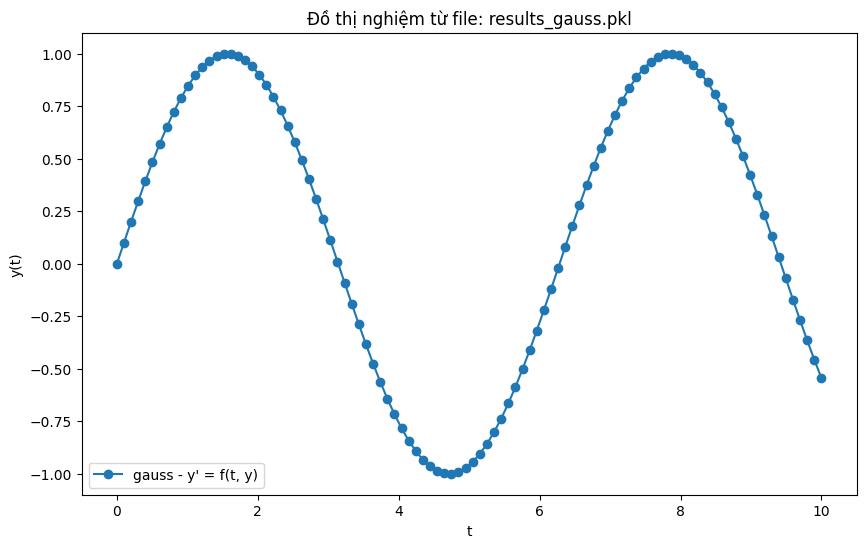

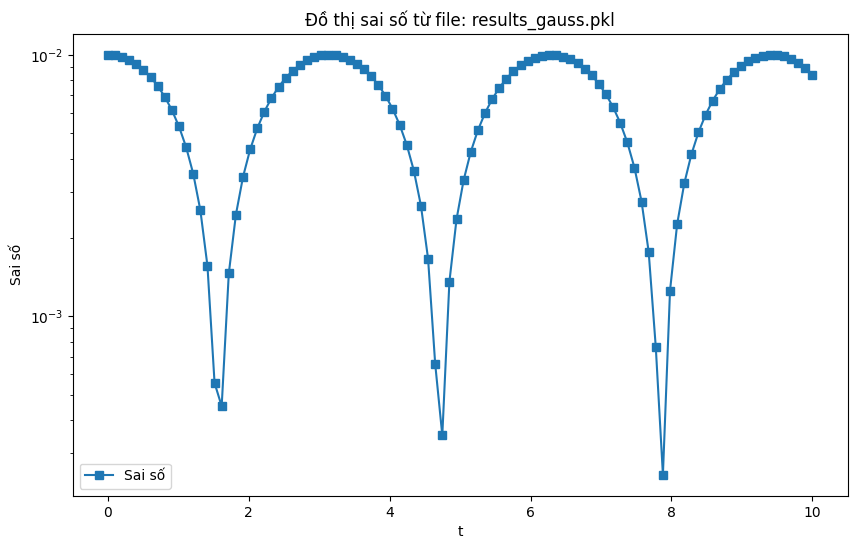


=== So sánh kết quả của các phương pháp ===
[INFO] Load kết quả từ file 'results_gauss.pkl' thành công!
[INFO] Load kết quả từ file 'results_radau.pkl' thành công!
[INFO] Load kết quả từ file 'results_lobatto.pkl' thành công!


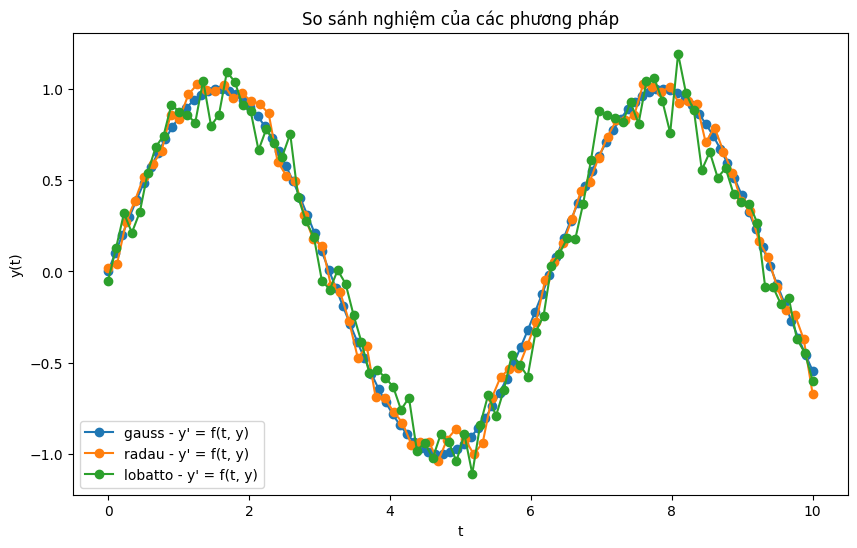

[WARNING] Phương pháp radau không có dữ liệu error.


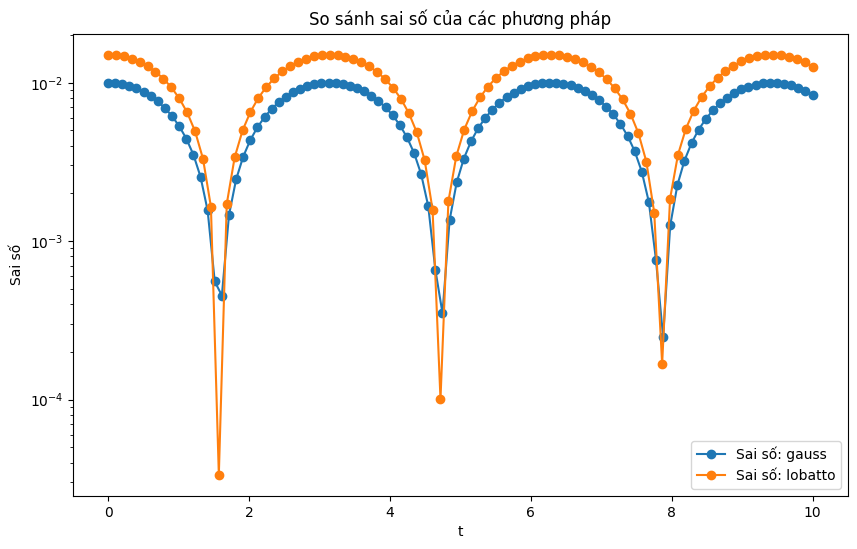

In [21]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# Hàm lưu kết quả tính toán vào file pickle
# =====================================================
def save_results(filename, ts, ys, errors, h_min, h_max, method_name, equation_name, additional_info=None):
    """
    Lưu kết quả tính toán vào file sử dụng pickle.
    
    Tham số:
      - filename: Tên file lưu kết quả (ví dụ: "results.pkl").
      - ts: Mảng thời gian các bước.
      - ys: Nghiệm tại các bước thời gian (có thể là mảng 1D hoặc 2D).
      - errors: Sai số tương ứng (hoặc None nếu không có).
      - h_min: Bước h nhỏ nhất sử dụng.
      - h_max: Bước h lớn nhất sử dụng.
      - method_name: Tên phương pháp/thuật toán (ví dụ: "gauss", "radau", …).
      - equation_name: Mô tả hoặc tên phương trình đang giải.
      - additional_info: Dictionary chứa các thông tin bổ sung (tùy chọn).
    
    Hàm tạo dictionary chứa các thông tin trên và lưu vào file filename.
    """
    results = {
        "ts": ts,
        "ys": ys,
        "errors": errors,
        "h_min": h_min,
        "h_max": h_max,
        "n_steps": len(ts),
        "method_name": method_name,
        "equation_name": equation_name,
    }
    if additional_info:
        results.update(additional_info)
    
    with open(filename, "wb") as f:
        pickle.dump(results, f)
    print(f"[INFO] Lưu kết quả thành công vào file '{filename}'")

# =====================================================
# Hàm load kết quả từ file pickle
# =====================================================
def load_results(filename):
    """
    Load kết quả tính toán từ file pickle.
    
    Tham số:
      - filename: Tên file chứa kết quả (ví dụ: "results_gauss.pkl").
      
    Hàm trả về dictionary chứa kết quả lưu trữ.
    """
    with open(filename, "rb") as f:
        results = pickle.load(f)
    print(f"[INFO] Load kết quả từ file '{filename}' thành công!")
    return results

# =====================================================
# Hàm lưu đồ thị (plot) dưới dạng file ảnh
# =====================================================
def save_plot(filename, ts, ys, title="Đồ thị nghiệm", xlabel="t", ylabel="y(t)"):
    """
    Vẽ và lưu đồ thị nghiệm vào file ảnh.
    
    Tham số:
      - filename: Tên file ảnh (ví dụ: "solution.png").
      - ts: Mảng thời gian.
      - ys: Nghiệm tương ứng (nếu là vector thì lấy thành phần đầu tiên).
      - title: Tiêu đề đồ thị.
      - xlabel, ylabel: Nhãn các trục.
    """
    plt.figure(figsize=(10, 6))
    # Nếu ys là mảng 2D, sử dụng cột đầu tiên (thường dùng cho hệ vector)
    if np.ndim(ys) > 1:
        plt.plot(ts, ys[:, 0], 'o-', label="Nghiệm")
    else:
        plt.plot(ts, ys, 'o-', label="Nghiệm")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(filename)
    plt.close()
    print(f"[INFO] Lưu đồ thị thành công vào file '{filename}'")

# =====================================================
# Hàm mở file kết quả, hiển thị thông tin và đồ thị
# =====================================================
def open_and_view_result(filename):
    """
    Load kết quả từ file pickle và hiển thị thông tin cũng như vẽ đồ thị nghiệm.
    
    Tham số:
      - filename: Tên file chứa kết quả.
    """
    results = load_results(filename)
    
    # In ra thông tin kết quả (nếu là mảng thì in shape để không tràn console)
    print("\n=== Thông tin kết quả ===")
    for key, value in results.items():
        if isinstance(value, np.ndarray):
            print(f"{key}: shape {value.shape}")
        else:
            print(f"{key}: {value}")
    
    # Vẽ đồ thị nghiệm
    ts = results["ts"]
    ys = results["ys"]
    plt.figure(figsize=(10, 6))
    if np.ndim(ys) > 1:
        plt.plot(ts, ys[:, 0], 'o-', 
                 label=f'{results.get("method_name", "method")} - {results.get("equation_name", "equation")}')
    else:
        plt.plot(ts, ys, 'o-', 
                 label=f'{results.get("method_name", "method")} - {results.get("equation_name", "equation")}')
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("Đồ thị nghiệm từ file: " + filename)
    plt.legend()
    plt.show()
    
    # Nếu có dữ liệu "errors", vẽ đồ thị sai số
    if "errors" in results and results["errors"] is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(results["ts"], results["errors"], 's-', label="Sai số")
        plt.xlabel("t")
        plt.ylabel("Sai số")
        plt.title("Đồ thị sai số từ file: " + filename)
        plt.legend()
        plt.yscale("log")
        plt.show()
    else:
        print("[WARNING] Dữ liệu không chứa phần 'errors', bỏ qua đồ thị sai số.")

# =====================================================
# Hàm so sánh kết quả của nhiều phương pháp từ nhiều file pickle
# =====================================================
def compare_multiple_results(filenames):
    """
    So sánh nghiệm và sai số (nếu có) của nhiều phương pháp từ danh sách file pickle.
    
    Tham số:
      - filenames: Danh sách tên file chứa kết quả cần so sánh.
      
    Hàm vẽ đồ thị so sánh nghiệm trên cùng 1 biểu đồ, và nếu dữ liệu lỗi tồn tại thì cũng vẽ đồ thị sai số.
    """
    # Load tất cả các file kết quả
    results_list = [load_results(fn) for fn in filenames]
    
    # Vẽ đồ thị nghiệm so sánh
    plt.figure(figsize=(10, 6))
    for results in results_list:
        ts = results["ts"]
        ys = results["ys"]
        y_sol = ys[:, 0] if np.ndim(ys) > 1 else ys
        plt.plot(ts, y_sol, marker='o', linestyle='-', 
                 label=f'{results.get("method_name", "method")} - {results.get("equation_name", "equation")}')
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("So sánh nghiệm của các phương pháp")
    plt.legend()
    plt.show()
    
    # Vẽ đồ thị sai số nếu có dữ liệu "errors"
    any_error = any("errors" in results and results["errors"] is not None for results in results_list)
    if any_error:
        plt.figure(figsize=(10, 6))
        for results in results_list:
            if "errors" in results and results["errors"] is not None:
                plt.plot(results["ts"], results["errors"], marker='o', linestyle='-', 
                         label=f'Sai số: {results.get("method_name", "method")}')
            else:
                print(f"[WARNING] Phương pháp {results.get('method_name', 'unknown')} không có dữ liệu error.")
        plt.xlabel("t")
        plt.ylabel("Sai số")
        plt.title("So sánh sai số của các phương pháp")
        plt.legend()
        plt.yscale("log")
        plt.show()
    else:
        print("[INFO] Không có dữ liệu sai số cho bất kỳ phương pháp nào, bỏ qua phần so sánh sai số.")

# =====================================================
# Ví dụ sử dụng toàn bộ chức năng (lưu, mở, so sánh)
# =====================================================
if __name__ == "__main__":
    # ---------------------------
    # Ví dụ 1: Lưu kết quả từ phương pháp Gauss (có dữ liệu sai số)
    # ---------------------------
    ts_gauss = np.linspace(0, 10, 100)           # Mảng thời gian từ 0 đến 10 với 100 bước
    ys_gauss = np.sin(ts_gauss)                  # Giả sử nghiệm là sin(t)
    errors_gauss = np.abs(np.cos(ts_gauss)) * 0.01 # Sai số mẫu (ví dụ so sánh với nghiệm chính xác)
    h_min = 0.05                                 # Bước h nhỏ nhất
    h_max = 0.1                                  # Bước h lớn nhất
    method_name_gauss = "gauss"
    equation_name_gauss = "y' = f(t, y)"
    
    save_results("results_gauss.pkl", ts_gauss, ys_gauss, errors_gauss, h_min, h_max,
                 method_name_gauss, equation_name_gauss)
    save_plot("solution_gauss.png", ts_gauss, ys_gauss, 
              title="Đồ thị nghiệm mẫu - Gauss", xlabel="t", ylabel="y(t)")
    
    # ---------------------------
    # Ví dụ 2: Lưu kết quả từ phương pháp Radau (không có dữ liệu 'errors')
    # ---------------------------
    ts_radau = np.linspace(0, 10, 80)  # Số bước khác nhau
    # Nghiệm có nhiễu nhỏ
    ys_radau = np.sin(ts_radau) + 0.05 * np.random.randn(80)
    # Không truyền dữ liệu sai số (None)
    method_name_radau = "radau"
    equation_name_radau = "y' = f(t, y)"
    
    save_results("results_radau.pkl", ts_radau, ys_radau, None, h_min, h_max,
                 method_name_radau, equation_name_radau)
    save_plot("solution_radau.png", ts_radau, ys_radau, 
              title="Đồ thị nghiệm mẫu - Radau", xlabel="t", ylabel="y(t)")
    
    # ---------------------------
    # Ví dụ 3: Lưu kết quả từ phương pháp Lobatto (có dữ liệu sai số)
    # ---------------------------
    ts_lobatto = np.linspace(0, 10, 90)
    ys_lobatto = np.sin(ts_lobatto) + 0.1 * np.random.randn(90)
    errors_lobatto = np.abs(np.cos(ts_lobatto)) * 0.015
    method_name_lobatto = "lobatto"
    equation_name_lobatto = "y' = f(t, y)"
    
    save_results("results_lobatto.pkl", ts_lobatto, ys_lobatto, errors_lobatto, h_min, h_max,
                 method_name_lobatto, equation_name_lobatto)
    save_plot("solution_lobatto.png", ts_lobatto, ys_lobatto, 
              title="Đồ thị nghiệm mẫu - Lobatto", xlabel="t", ylabel="y(t)")
    
    # ---------------------------
    # Mở file kết quả đơn lẻ để xem thông tin và đồ thị
    # ---------------------------
    print("\n=== Mở file kết quả của phương pháp Gauss ===")
    open_and_view_result("results_gauss.pkl")
    
    # ---------------------------
    # So sánh nghiệm và sai số của nhiều phương pháp cùng lúc
    # ---------------------------
    file_list = ["results_gauss.pkl", "results_radau.pkl", "results_lobatto.pkl"]
    print("\n=== So sánh kết quả của các phương pháp ===")
    compare_multiple_results(file_list)
